### Step1 import package & set path

In [1]:
import os
from asammdf import MDF
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

In [2]:
# 导入需要的资源路径
rootPath = r'C:\Users\YCAI40\OneDrive - Volvo Cars\case\energy_consumption\data_new\RWEC3.0\HPT2001\2021-09-01_Wednesday_High'
fileName = 'RWEC_XC40_HPT2001_20210901_High_T005.mdf'

path = os.path.join(rootPath,fileName)


data = MDF(path)
data.info()

{'version': '4.10',
 'program': 'MDF4Lib',
 'comment': '<HDcomment><TX /><common_properties><e name="Measurement.UUID">d1341ea8-961a-46ca-b828-793c551c5aeb</e><e name="Recorder.UUID">68e2651f-fd8e-47e2-87e2-f78bdd91048e</e><e name="Recorder.Name">Logging</e><e name="Recorder.FileIndex">0</e></common_properties></HDcomment>',
 'groups': 738,
 'group 0': {'cycles': 8148,
  'comment': '',
  'channels count': 2,
  'channel 0': 'name="Busload" type=VALUE',
  'channel 1': 'name="t" type=MASTER'},
 'group 1': {'cycles': 8148,
  'comment': '',
  'channels count': 2,
  'channel 0': 'name="BusloadAvg" type=VALUE',
  'channel 1': 'name="t" type=MASTER'},
 'group 2': {'cycles': 8148,
  'comment': '',
  'channels count': 2,
  'channel 0': 'name="BusloadMin" type=VALUE',
  'channel 1': 'name="t" type=MASTER'},
 'group 3': {'cycles': 8148,
  'comment': '',
  'channels count': 2,
  'channel 0': 'name="BusloadMax" type=VALUE',
  'channel 1': 'name="t" type=MASTER'},
 'group 4': {'cycles': 8148,
  'comm

### Step2 MDF to CSV

In [3]:
dataFiltered = data.filter([('VehSpdLgtSafe',354,15),('ALgt1',640,5),('BkpOfDstTrvld',337,0),
                            'HvBattPwr','HvThermPwrCns','RoadIncln','VehM','HvHeatrPwrCns2'],'AmbTIndcd')  

# ('VehSpdLgtSafe',354,15),('VehSpdLgtSafe',355,6),('VehSpdLgtSafe',366,7),('VehSpdLgtSafe',395,4),('VehSpdLgtSafe',525,19),
# ('ALgt1',640,5),('ALgt1',641,5),('ALgt1',698,5)
# ('BkpOfDstTrvld',337,0),('BkpOfDstTrvld',486,2),('BkpOfDstTrvld',487,0),('BkpOfDstTrvld',501,0),('BkpOfDstTrvld',599,0),'AmbTIndcd'

df = dataFiltered.to_dataframe(time_as_date=True)  # 得到dataframe
# 把提取的字段保留下来，留作以后使用
df.head()

,VehSpdLgtSafe,ALgt1,BkpOfDstTrvld,HvBattPwr,HvThermPwrCns,RoadIncln,VehM,HvHeatrPwrCns2
timestamps,,,,,,,,
2021-09-01 17:21:15.001700+08:00,0.0,0.0,13873,0.0,0.0,0.0,2310,0.0
2021-09-01 17:21:15.002390+08:00,0.0,0.0,13873,0.0,0.0,0.0,2310,0.0
2021-09-01 17:21:15.012420+08:00,0.0,0.0,13873,0.0,0.0,0.0,2310,0.0
2021-09-01 17:21:15.017000+08:00,0.0,0.0,13873,0.0,0.0,0.0,2310,0.0
2021-09-01 17:21:15.017240+08:00,0.0,0.0,13873,0.0,0.0,0.0,2310,0.0


In [4]:

df = df.rename(columns={'VehSpdLgtSafe':'speed',
                        'ALgt1':'acceleration',
                        'BkpOfDstTrvld':'total_driven_distance',
                        'HvBattPwr':'output_power',
                        'HvThermPwrCns':'thermal_system_power_consumption',
                        'RoadIncln':'inclination',
                        'VehM':'vehicle_mass',
                        'HvHeatrPwrCns2':'AC_consumption'})


print("数据量为：",len(df))
df['speed(km/h)'] = df['speed'] * 3.6
df.describe()



数据量为： 2684402


,speed,acceleration,total_driven_distance,output_power,thermal_system_power_consumption,inclination,vehicle_mass,AC_consumption,speed(km/h)
count,2.684402e+06,2.684402e+06,2.684402e+06,2.684402e+06,2.684402e+06,2.684402e+06,2.684402e+06,2.684402e+06,2.684402e+06
mean,1.298774e+01,-8.215571e-02,1.392054e+04,9.521932e+00,1.703009e+03,8.691027e-03,2.376827e+03,5.373639e+01,4.675587e+01
std,1.116340e+01,5.479626e-01,3.700022e+01,1.843174e+01,7.400619e+02,1.001069e-02,2.020019e+01,5.905683e+02,4.018825e+01
min,0.000000e+00,-3.510500e+00,1.387300e+04,-9.650000e+01,0.000000e+00,-5.755695e-02,2.310000e+03,0.000000e+00,0.000000e+00
25%,0.000000e+00,-2.758671e-01,1.388700e+04,1.250000e+00,1.260000e+03,2.478441e-03,2.365000e+03,0.000000e+00,0.000000e+00
50%,1.340348e+01,-1.023388e-01,1.391100e+04,2.500000e+00,1.540000e+03,7.823464e-03,2.373000e+03,0.000000e+00,4.825253e+01
75%,2.298298e+01,7.472551e-02,1.396500e+04,1.790511e+01,1.980000e+03,1.402149e-02,2.398000e+03,0.000000e+00,8.273873e+01
max,3.748908e+01,3.094000e+00,1.397700e+04,1.607500e+02,7.340000e+03,8.508418e-02,2.414000e+03,7.340000e+03,1.349607e+02


In [5]:
#accelearation smoothing method
def savitzky_golay(y, window_size, order, deriv=0, rate=1):

    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except (ValueError):
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [6]:
acc_hat = savitzky_golay(df['acceleration'], 3001, 4) # window size 51, polynomial order 3


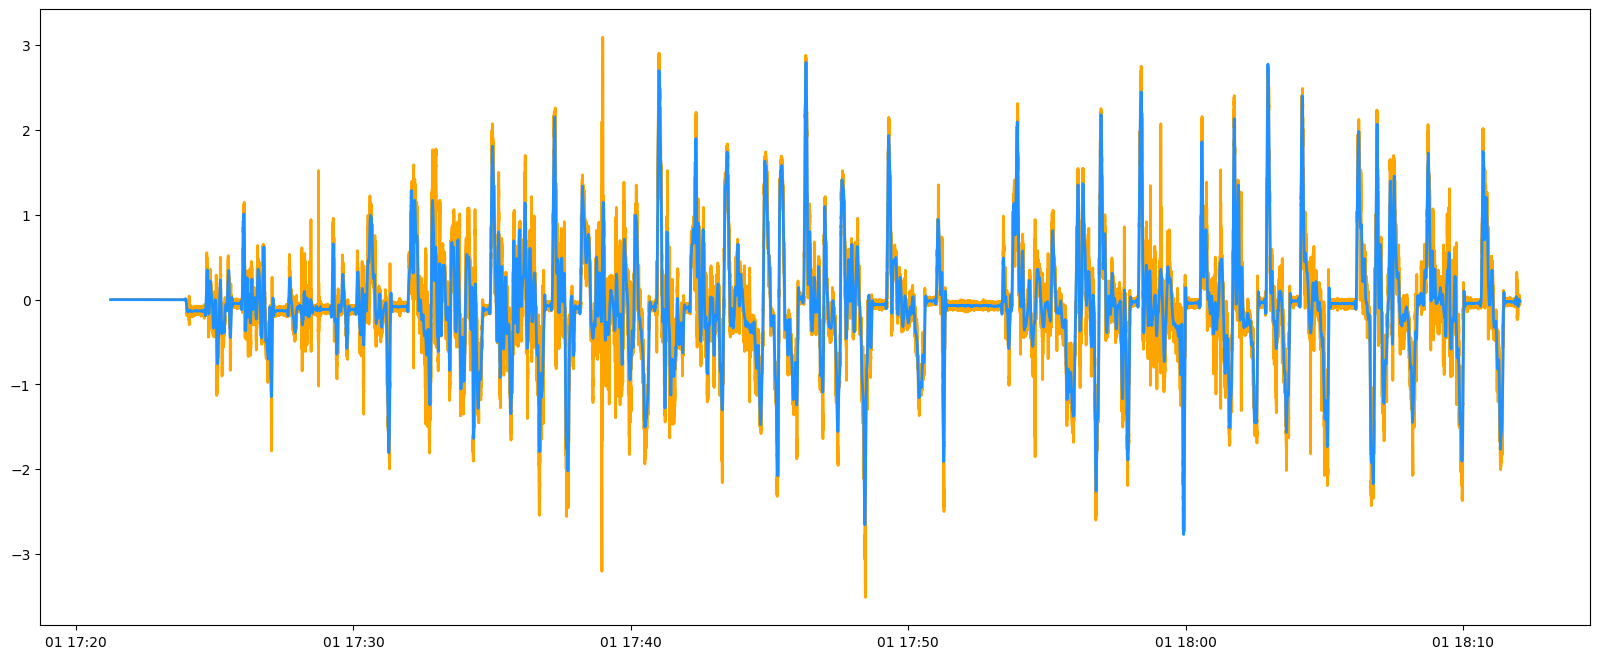

In [8]:

plt.figure(figsize=(20, 8))
plt.plot(df.index[:1000000],df['acceleration'][:1000000],c='orange',linewidth=2)
plt.plot(df.index[:1000000],acc_hat[:1000000], color='dodgerblue',linewidth=2)

plt.show()

In [7]:
df['acceleration'] = acc_hat
df_second = df.resample('0.1S').mean()

### Step3 EDA

#### speed & acceleration

<Axes: xlabel='inclination', ylabel='output_power'>

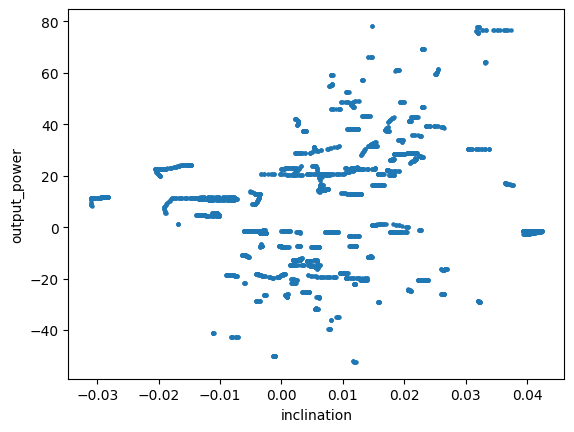

In [ ]:
#inclination and output power at speed = 40
speed_40 = df.loc[(df['speed(km/h)']>39.9)  & (df['speed(km/h)']<40.1)]
speed_40.plot.scatter(x='inclination',y='output_power',s=5)

thermal_in
False    2668038
True       16364
Name: count, dtype: int64

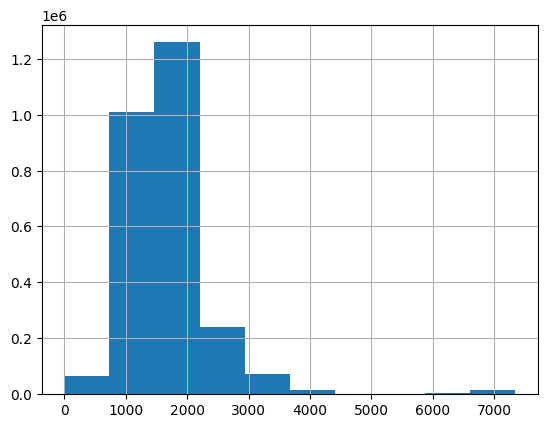

In [ ]:
df['thermal_in'] = df['thermal_system_power_consumption']<df['output_power']
df['thermal_system_power_consumption'].hist()
df['thermal_in'].value_counts()


AC_percentage
True     2161648
False     522754
Name: count, dtype: int64

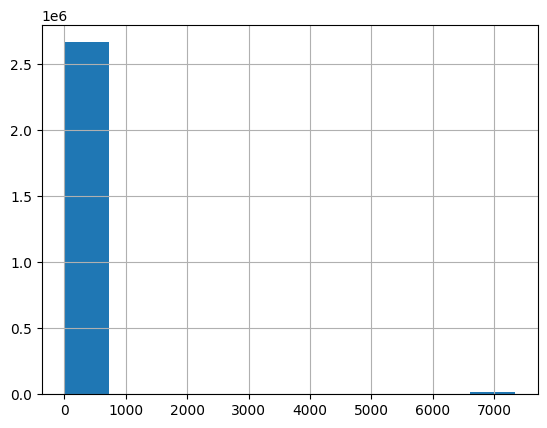

In [ ]:
df['AC_percentage'] = df['AC_consumption']<df['output_power']
df['AC_consumption'].hist()
df['AC_percentage'].value_counts()

In [7]:
kinematic = df[['speed(km/h)','output_power']]
# 查看速度和power relation
speed_20 = kinematic.loc[(kinematic['speed(km/h)']<20)]['output_power'].to_numpy()
speed_40 = kinematic.loc[(kinematic['speed(km/h)']>20) & (kinematic['speed(km/h)']<40)]['output_power'].to_numpy()
speed_60 = kinematic.loc[(kinematic['speed(km/h)']>40) & (kinematic['speed(km/h)']<60)]['output_power'].to_numpy()
speed_80 = kinematic.loc[(kinematic['speed(km/h)']>60) & (kinematic['speed(km/h)']<80)]['output_power'].to_numpy()
speed_100 = kinematic.loc[(kinematic['speed(km/h)']>80) & (kinematic['speed(km/h)']<100)]['output_power'].to_numpy()
speed_120 = kinematic.loc[(kinematic['speed(km/h)']>100) & (kinematic['speed(km/h)']<120)]['output_power'].to_numpy()
speed_140 = kinematic.loc[(kinematic['speed(km/h)']>120)]['output_power'].to_numpy()

speed_range = [speed_20, speed_40,speed_60,speed_80,speed_100,speed_120,speed_140]

Text(0, 0.5, 'power')

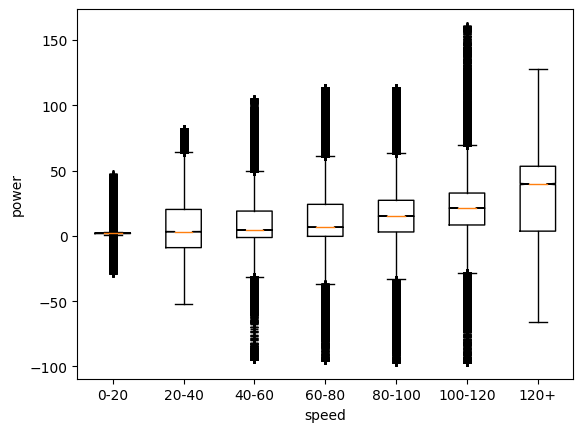

In [8]:
speed_labels = ['0-20','20-40','40-60','60-80','80-100','100-120','120+']
fig, ax = plt.subplots()
pos = np.arange(len(speed_range)) + 1
ax.boxplot(speed_range, sym='k+', positions=pos,
                notch=True)
ax.set_xlabel('speed')
ax.set_xticklabels(speed_labels)
ax.set_ylabel('power')

In [12]:
df.columns

Index(['speed', 'acceleration', 'total_driven_distance', 'output_power',
       'thermal_system_power_consumption', 'inclination', 'vehicle_mass',
       'AC_consumption', 'speed(km/h)', 'power_sum'],
      dtype='object')

In [9]:
df['power_sum'] = df['output_power'].cumsum()

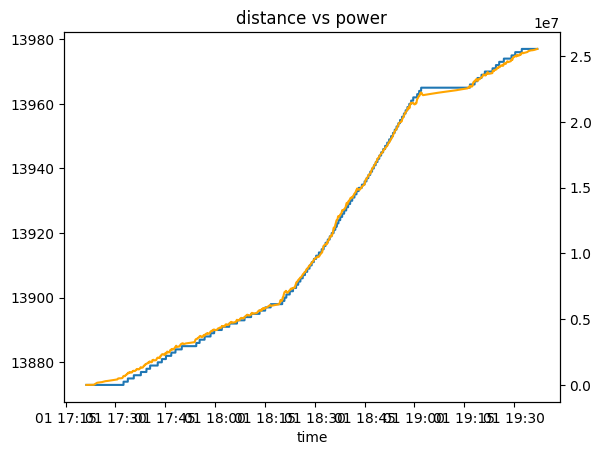

In [10]:
fig,ax = plt.subplots()

ax.set(title = 'distance vs power', xlabel ='time')
ax.plot(df.index,df['total_driven_distance'])
ax2 = ax.twinx()
ax2.plot(df.index,df['power_sum'],c='orange')
plt.show()

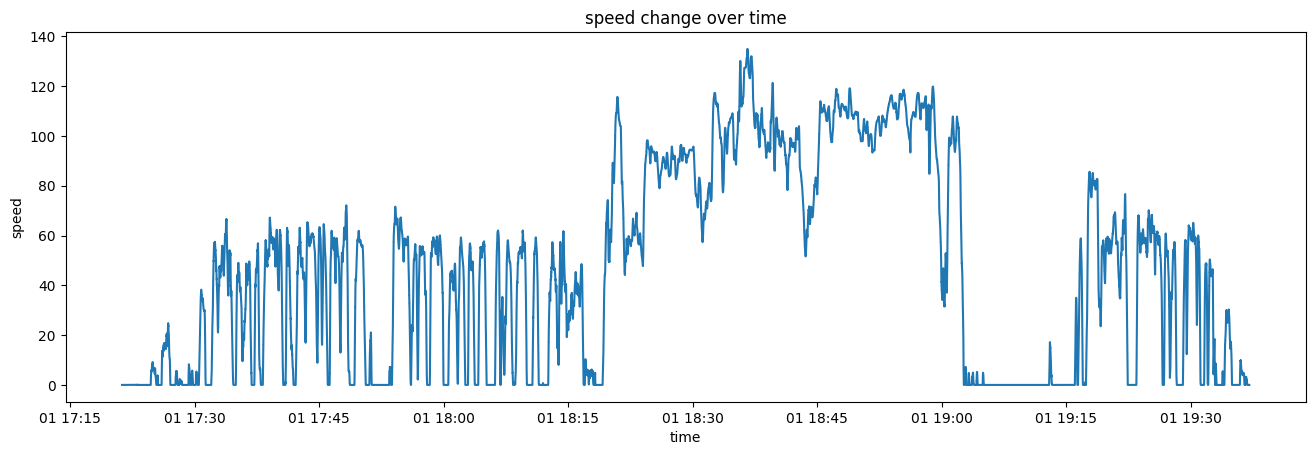

In [ ]:
fig,ax = plt.subplots()
fig.set_figwidth(16)
ax.set(title = 'speed change over time', xlabel ='time',ylabel = 'speed')
ax.plot(df.index,df['speed(km/h)'])


plt.show()

### Step4 Data Cleaning (stop time > 200)

In [8]:
df_second = df_second.reset_index()

In [9]:
# find all the stop time withint entire driving cycle
def findAllZero(df: pd.DataFrame,factor:str,time:str) -> pd.DataFrame:
    segments = []
    start = None
    for index,_ in df.iterrows():
        if df.loc[index,factor] == 0:
            if start is None:
                start = df.loc[index,time]
        else:
            if start is not None:
                segments.append([start,df.loc[index,time]])
                start = None
    if start is not None:
        segments.append([start,df.loc[len(df)-1,time]])
    stop = pd.DataFrame(columns=['start','end'],data = segments)
    return stop

# 找到所有的连续为0数据的时间段并计算连续停留的时间长度
stop = findAllZero(df_second,'speed(km/h)','timestamps')

In [10]:
stop['timeLength'] = [(row['end']-row['start']).total_seconds() for _,row in stop.iterrows()]
delete = stop.loc[stop['timeLength']>=200]
idling = stop.loc[stop['timeLength']<200]

In [11]:
# delete idling period according to CLTC 200 seconds


def deleteZeroDf(df:pd.DataFrame,delete:pd.DataFrame)->pd.DataFrame:
    for index,_ in delete.iterrows():
        start = delete.loc[index,'start']
        end = delete.loc[index,'end']
        df = df[(df['timestamps'] < start) | (df['timestamps'] > end)]
    return df

df_200 = deleteZeroDf(df_second,delete)


In [12]:
df_200['label']='moving'

C:\Users\YCAI40\AppData\Local\Temp\ipykernel_35832\3654976282.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_200['label']='moving'


In [13]:
for i,r in idling.iterrows():
    label_i = (df_200['timestamps'] >= r['start']) & (df_200['timestamps'] <= r['end'])
    df_200.loc[label_i,'label']='idling'

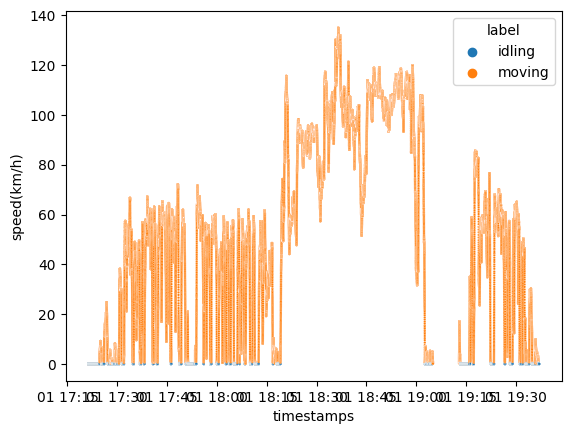

In [14]:
#moving and idling graph
sns.scatterplot(df_200, x='timestamps', y='speed(km/h)', hue='label',s=3)
plt.show()

In [15]:
#create group id each changing phase as a stop
label_changes = df_200['label'].ne(df_200['label'].shift())
group_id = label_changes.cumsum()
df_200['group_id']=group_id

C:\Users\YCAI40\AppData\Local\Temp\ipykernel_35832\3133835960.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_200['group_id']=group_id


In [16]:
#generate cycle_id by combining a moving piece and idling piece
df_200['cycle_id']=df_200['group_id']//2

C:\Users\YCAI40\AppData\Local\Temp\ipykernel_35832\2465733186.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_200['cycle_id']=df_200['group_id']//2


C:\Users\YCAI40\AppData\Local\Temp\ipykernel_35832\3560616150.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df_200.index.to_numpy()[ix], df_200['speed(km/h)'].to_numpy()[ix], c = color_map[g], label = g, s = Size)


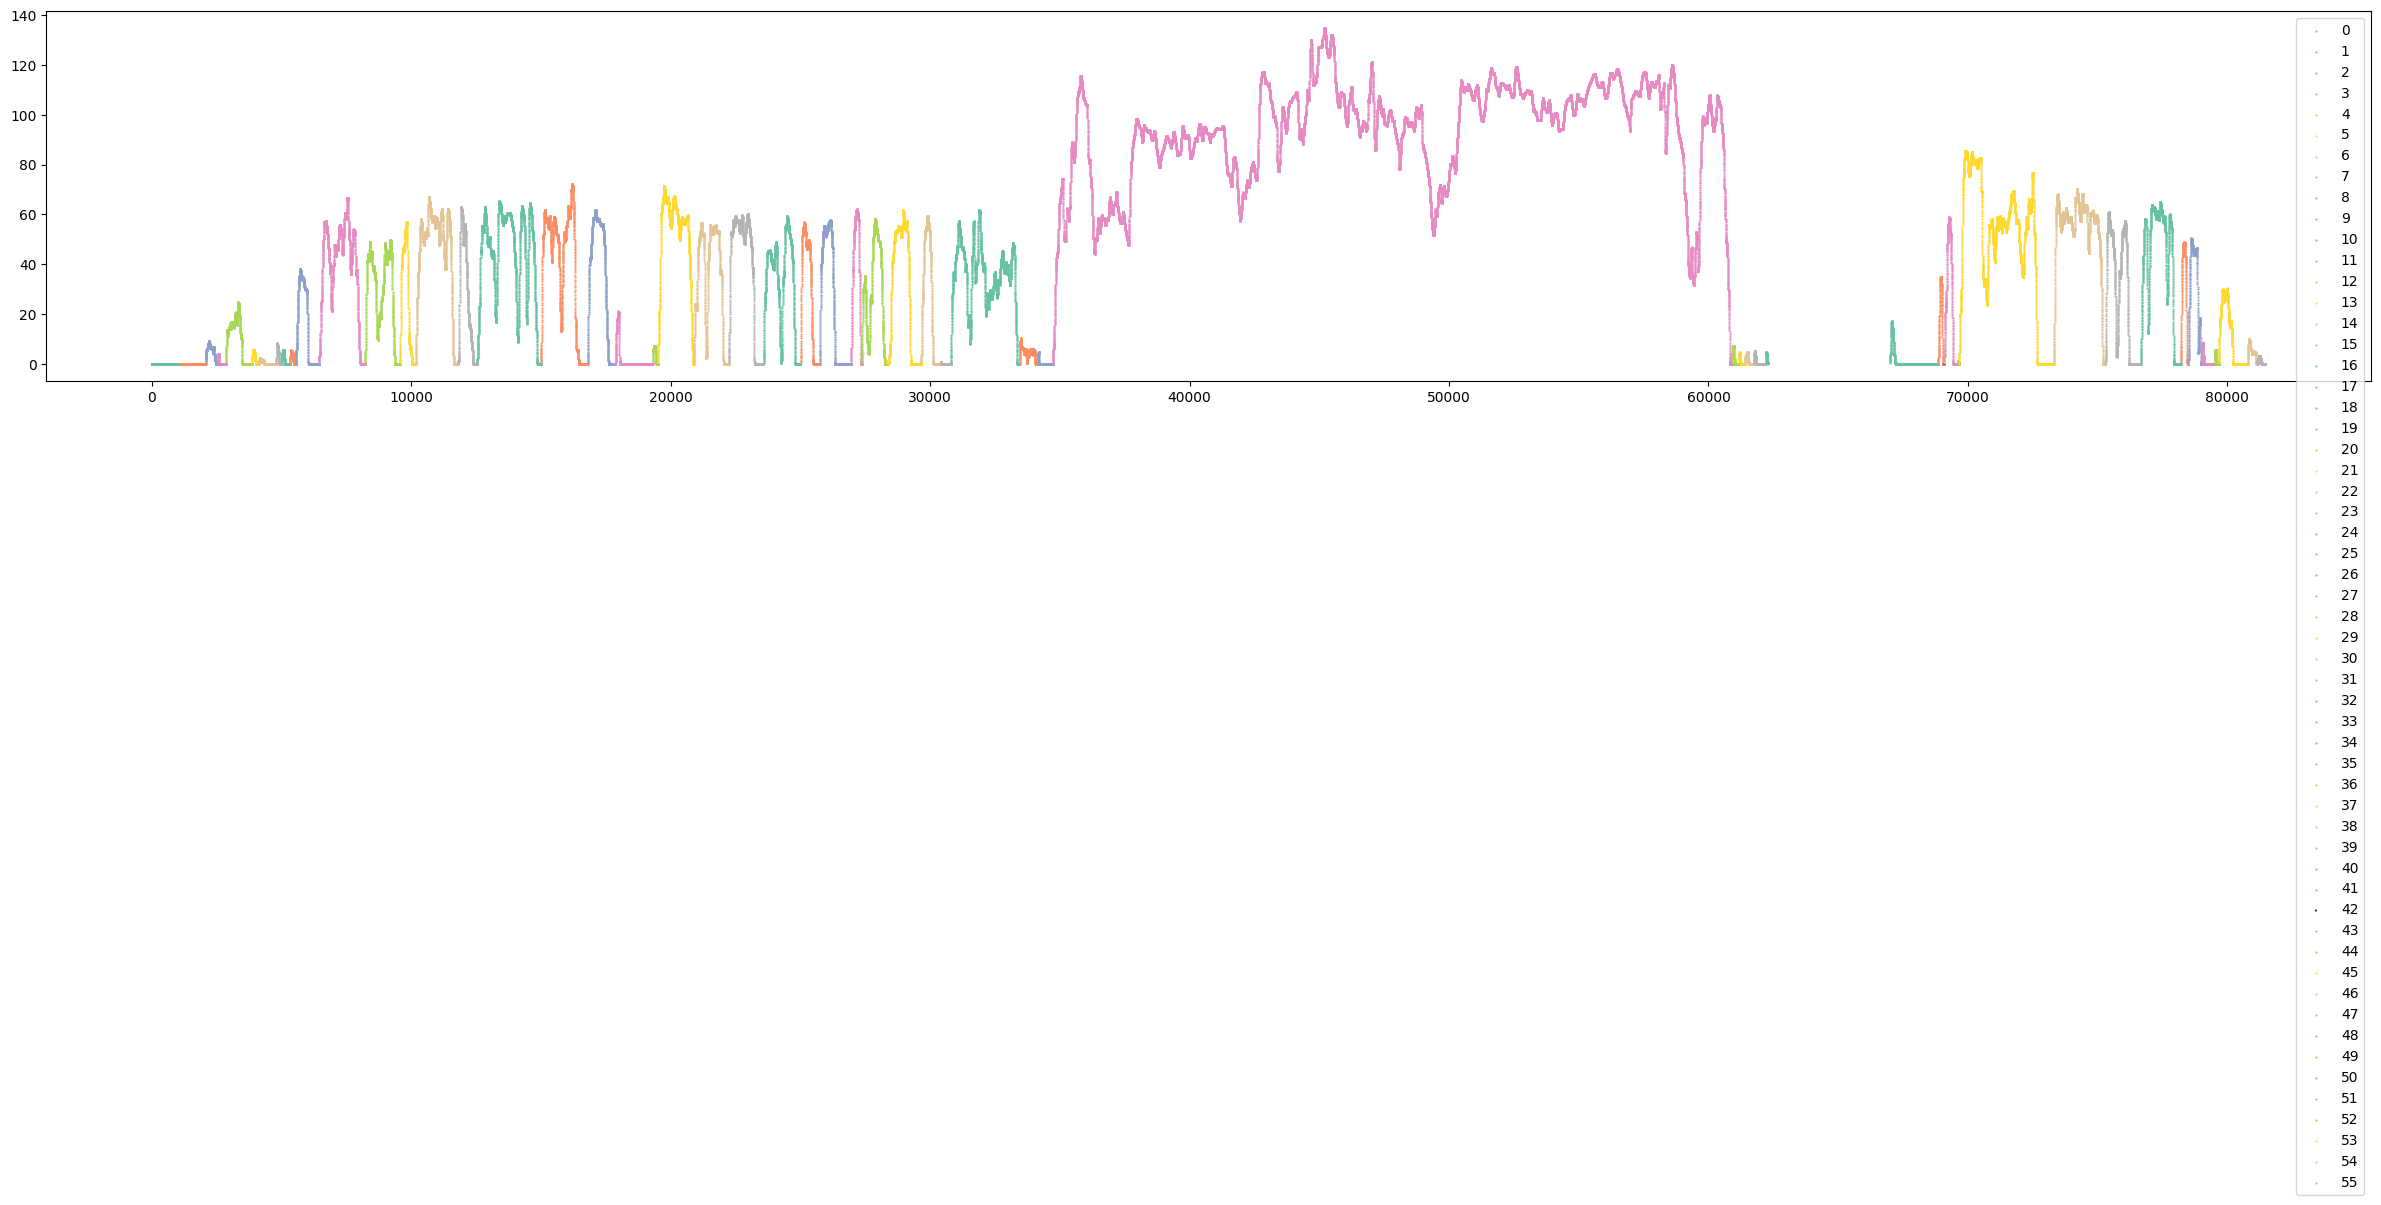

In [17]:
#plot cycle: a moving piece followed by an idling piece
color_labels = df_200['cycle_id'].unique()
rgb_values = sns.color_palette("Set2", 56)
# Map continents to the colors
color_map = dict(zip(color_labels, rgb_values))

fig, ax = plt.subplots()
fig.set_figwidth(30)
Size = 0.3
for g in np.unique(df_200['cycle_id']):
    ix = np.where(df_200['cycle_id'] == g)

    ax.scatter(df_200.index.to_numpy()[ix], df_200['speed(km/h)'].to_numpy()[ix], c = color_map[g], label = g, s = Size)
ax.legend()
plt.show()

In [19]:
df_200.to_csv('groupedData/RWEC_XC40_HPT2001_20210901_High_T005.csv')

In [165]:
df_200.head()


,timestamps,speed,acceleration,total_driven_distance,output_power,thermal_system_power_consumption,inclination,vehicle_mass,AC_consumption,speed(km/h),label,group_id,cycle_id,speed_label_x,speed_bin,speed_label_y,speed_label
0,2021-09-01 17:21:15+08:00,0.0,0.0,13873.0,0.0,0.0,0.0,2310.0,0.0,0.0,idling,1,0,low,0-20,low,low
1,2021-09-01 17:21:15.100000+08:00,0.0,0.0,13873.0,0.0,0.0,0.0,2310.0,0.0,0.0,idling,1,0,low,0-20,low,low
2,2021-09-01 17:21:15.200000+08:00,0.0,0.0,13873.0,0.0,0.0,0.0,2310.0,0.0,0.0,idling,1,0,low,0-20,low,low
3,2021-09-01 17:21:15.300000+08:00,0.0,0.0,13873.0,0.0,0.0,0.0,2310.0,0.0,0.0,idling,1,0,low,0-20,low,low
4,2021-09-01 17:21:15.400000+08:00,0.0,0.0,13873.0,0.0,0.0,0.0,2310.0,0.0,0.0,idling,1,0,low,0-20,low,low


In [23]:
#generate cycle information
grouped = df_200.groupby('cycle_id')

idling_percentage = grouped.apply(lambda x: (x['label'] =='idling').mean()*100)
speed_avg = grouped['speed(km/h)'].mean()
speed_max = grouped['speed(km/h)'].max()
acceleration_avg = grouped['acceleration'].mean()
acceleration_std = grouped['acceleration'].std()
mileage = grouped['total_driven_distance'].max() - grouped['total_driven_distance'].min()
time = grouped['timestamps'].max() - grouped['timestamps'].min()
energy = grouped['output_power'].sum()

df_cycle = pd.DataFrame({
    'cycle_id':idling_percentage.index,
    'idling_percentage':idling_percentage.values,
    'average_speed':speed_avg.values,
    'max_speed':speed_max.values,
    'average_acc':acceleration_avg.values,
    'std_acc':acceleration_std.values,
    'mileage':mileage.values,
    'time':time.values,
    'energy':energy.values
})

In [24]:
# labeling cycle based on speed edge in CLTC: 60, 80
def speed_labels(speed):
    if (speed <60): return "low"
    if (speed >= 60) & (speed < 80): return "mid"
    else: return "high"



for index, item in df_cycle.iterrows():
    df_cycle.loc[index,'speed_label'] = speed_labels(df_cycle.loc[index,'max_speed'])
    print("\r",index,end = '')

 55

In [25]:
df_cycle['cycle_id']=df_cycle['cycle_id'].astype('int64')
df_200 = df_200.merge(df_cycle[['cycle_id','speed_label']], on='cycle_id',how='left')

In [26]:
df_200['speed_label'].unique()

array(['low', 'mid', 'high'], dtype=object)

C:\Users\YCAI40\AppData\Local\Temp\ipykernel_10640\2619225222.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df_200.index.to_numpy()[ix], df_200['speed(km/h)'].to_numpy()[ix], c = color_map[g], label = g, s = Size)


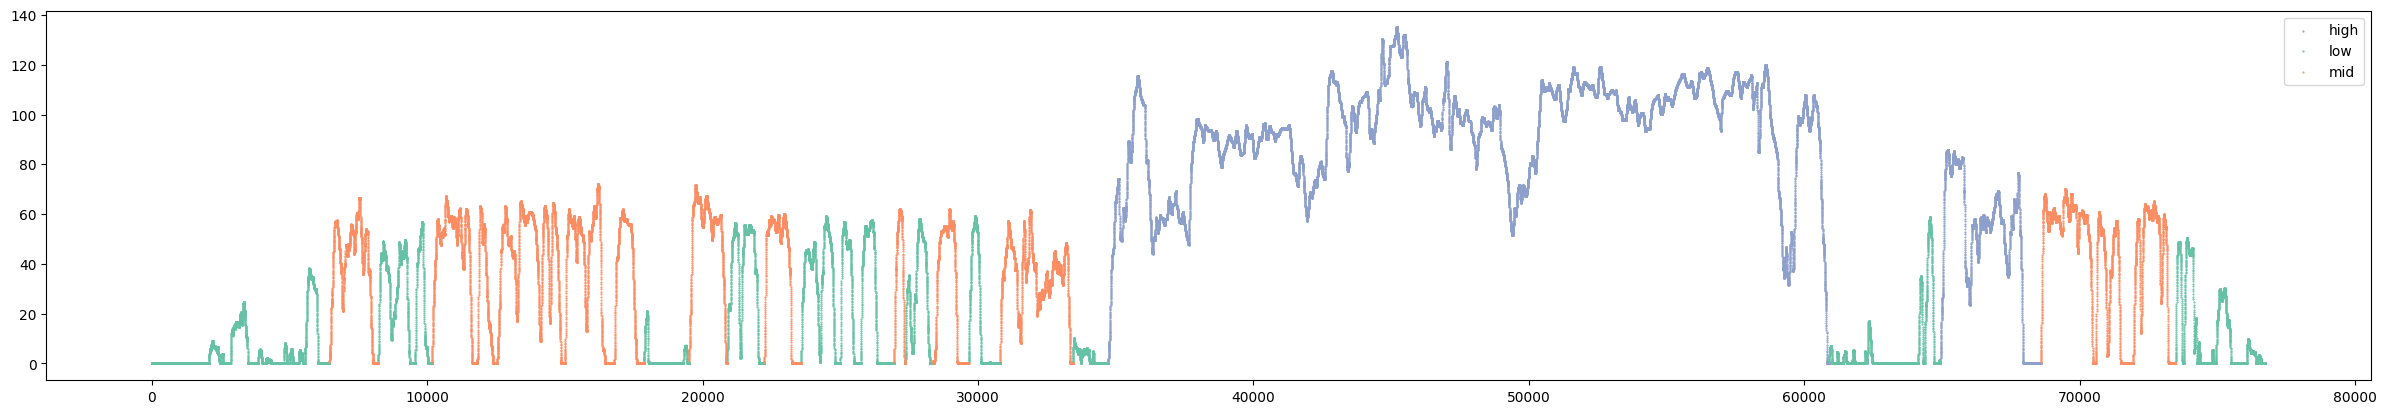

In [27]:
#plot low, mid, high based on speed label
color_labels = df_200['speed_label'].unique()
rgb_values = sns.color_palette("Set2", 3)
color_map = dict(zip(color_labels, rgb_values))

fig, ax = plt.subplots()
fig.set_figwidth(30)
Size = 0.3
for g in np.unique(df_200['speed_label']):
    ix = np.where(df_200['speed_label'] == g)

    ax.scatter(df_200.index.to_numpy()[ix], df_200['speed(km/h)'].to_numpy()[ix], c = color_map[g], label = g, s = Size)
ax.legend()
plt.show()

<Axes: xlabel='speed(km/h)', ylabel='speed_label'>

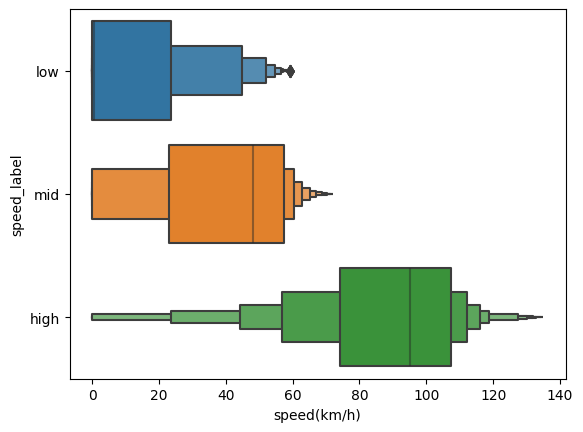

In [28]:
#speed label box plot
sns.boxenplot(data=df_200, x="speed(km/h)", y="speed_label")

<Axes: xlabel='acceleration', ylabel='speed_bin'>

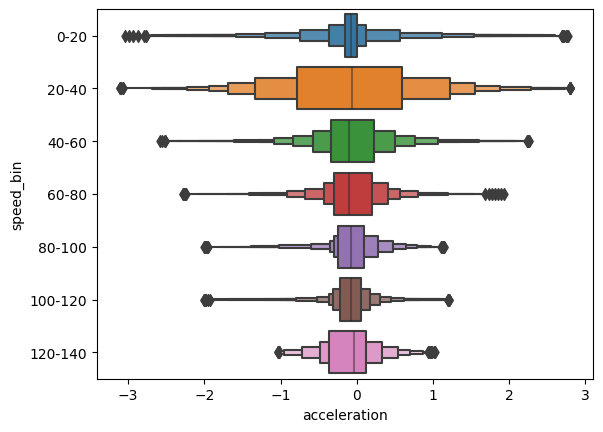

In [29]:
#speed bin box plot
speed_bins = [0,20,40,60,80,100,120,140]
speed_bin_labels = ['0-20','20-40','40-60','60-80','80-100','100-120','120-140']

df_200['speed_bin'] = pd.cut(df_200['speed(km/h)'],
                             bins=speed_bins,
                             labels=speed_bin_labels,
                             right=False)

low_group=df_200[df_200['speed_label']=='low']
sns.boxenplot(data=df_200,  y="speed_bin",x="acceleration")

In [30]:
df_200

,timestamps,speed,acceleration,total_driven_distance,output_power,thermal_system_power_consumption,inclination,vehicle_mass,AC_consumption,speed(km/h),label,group_id,cycle_id,speed_label,speed_bin
0,2021-09-01 17:21:15+08:00,0.0,0.000000,13873.0,0.00,0.0,0.000000,2310.0,0.0,0.0,idling,1,0,low,0-20
1,2021-09-01 17:21:15.100000+08:00,0.0,0.000000,13873.0,0.00,0.0,0.000000,2310.0,0.0,0.0,idling,1,0,low,0-20
2,2021-09-01 17:21:15.200000+08:00,0.0,0.000000,13873.0,0.00,0.0,0.000000,2310.0,0.0,0.0,idling,1,0,low,0-20
3,2021-09-01 17:21:15.300000+08:00,0.0,0.000000,13873.0,0.00,0.0,0.000000,2310.0,0.0,0.0,idling,1,0,low,0-20
4,2021-09-01 17:21:15.400000+08:00,0.0,0.000000,13873.0,0.00,0.0,0.000000,2310.0,0.0,0.0,idling,1,0,low,0-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76743,2021-09-01 19:37:01.100000+08:00,0.0,-0.115094,13977.0,3.75,3120.0,0.011669,2403.0,0.0,0.0,idling,111,55,low,0-20
76744,2021-09-01 19:37:01.200000+08:00,0.0,-0.113490,13977.0,3.75,3120.0,0.011697,2403.0,0.0,0.0,idling,111,55,low,0-20
76745,2021-09-01 19:37:01.300000+08:00,0.0,-0.112313,13977.0,3.75,3120.0,0.011879,2403.0,0.0,0.0,idling,111,55,low,0-20
76746,2021-09-01 19:37:01.400000+08:00,0.0,-0.111033,13977.0,3.75,3120.0,0.011827,2403.0,0.0,0.0,idling,111,55,low,0-20


### Traffic Index Generalization

#### Data Normalization + Preprocessing

In [175]:
df_cycle['time'] = df_cycle['time'].dt.seconds

In [176]:
df_cycle.describe()

,cycle_id,idling_percentage,average_speed,max_speed,average_acc,std_acc,mileage,time,energy
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,27.500000,37.389584,19.155113,36.137744,-0.066685,0.476697,1.857143,144.928571,13660.151883
std,16.309506,29.192433,19.731062,30.666647,0.129958,0.314525,8.918680,352.222030,63983.407294
min,0.000000,0.263620,0.000044,0.048990,-0.311723,0.000000,0.000000,0.000000,9.145699
25%,13.750000,13.657554,1.380654,5.604572,-0.083755,0.201692,0.000000,32.750000,870.112561
50%,27.500000,30.970248,15.613081,36.653567,-0.065329,0.417205,0.000000,73.500000,3284.913737
75%,41.250000,56.342113,32.636978,61.051131,-0.053880,0.705525,1.000000,135.250000,7553.023901
max,55.000000,100.000000,93.576191,134.960688,0.770764,1.233990,67.000000,2617.000000,481897.704708


In [177]:
from sklearn.preprocessing import MinMaxScaler
columns_to_normalize = ['idling_percentage','average_speed','max_speed','average_acc','std_acc','mileage','time']

df_cycle_normalized = df_cycle.copy()

scaler = MinMaxScaler()
df_cycle_normalized[columns_to_normalize] = scaler.fit_transform(df_cycle_normalized[columns_to_normalize])


In [178]:
df_cycle_normalized.describe()

,cycle_id,idling_percentage,average_speed,max_speed,average_acc,std_acc,mileage,time,energy
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,27.500000,0.372241,0.204700,0.267499,0.226366,0.386305,0.027719,0.055380,13660.151883
std,16.309506,0.292696,0.210856,0.227309,0.120056,0.254884,0.133115,0.134590,63983.407294
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.145699
25%,13.750000,0.134293,0.014754,0.041179,0.210596,0.163447,0.000000,0.012514,870.112561
50%,27.500000,0.307878,0.166848,0.271322,0.227618,0.338094,0.000000,0.028086,3284.913737
75%,41.250000,0.562267,0.348774,0.452163,0.238195,0.571743,0.014925,0.051681,7553.023901
max,55.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,481897.704708


#### Get feature importance from Random Forest

In [180]:
from sklearn.ensemble import RandomForestRegressor
features = ['idling_percentage','average_speed','max_speed','average_acc','std_acc','mileage','time']
target = 'energy'

model = RandomForestRegressor()
model.fit(df_cycle_normalized[features],df_cycle_normalized[target])

RandomForestRegressor()

In [185]:
importance = model.feature_importances_

In [214]:
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'],palette='coolwarm')
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

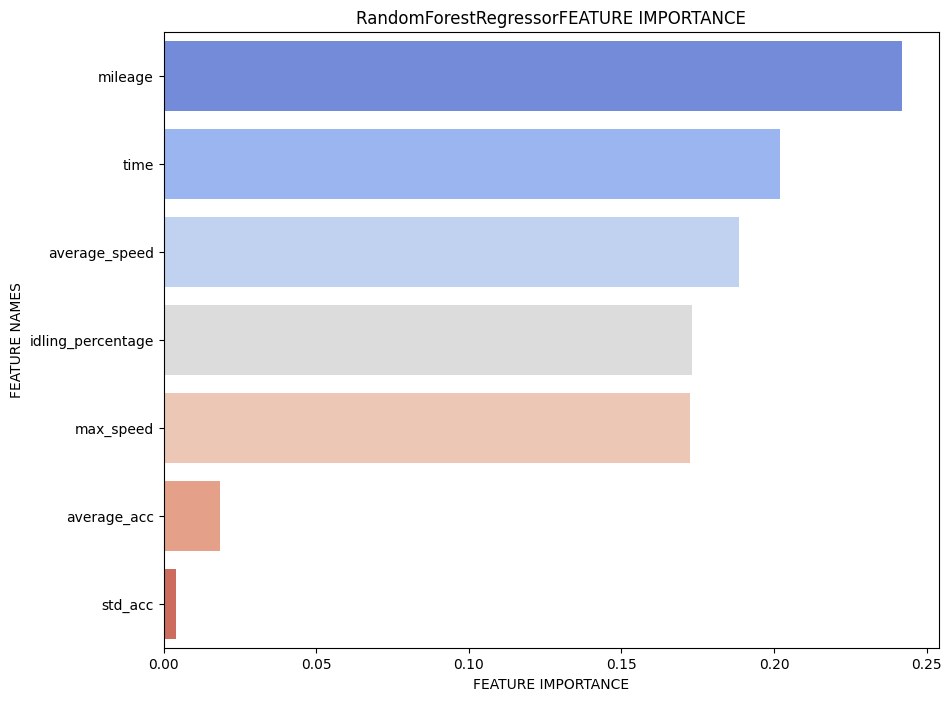

In [215]:
plot_feature_importance(importance, features,'RandomForestRegressor')

#### Traffic Index Calculation: weight*variable.sum()

In [216]:
weights = importance / importance.sum()
df_cycle_normalized['traffic_index'] = (df_cycle_normalized[features] * weights).sum(axis=1)

In [218]:
df_cycle_normalized['traffic_index'].describe()

count    56.000000
mean      0.172713
std       0.102512
min       0.044589
25%       0.126487
50%       0.171868
75%       0.206663
max       0.809917
Name: traffic_index, dtype: float64

In [ ]:
#plot low, mid, high based on speed label
color_labels = df_200['speed_label'].unique()
rgb_values = sns.color_palette("Set2", 3)
color_map = dict(zip(color_labels, rgb_values))

fig, ax = plt.subplots()
fig.set_figwidth(30)
Size = 0.3
for g in np.unique(df_200['speed_label']):
    ix = np.where(df_200['speed_label'] == g)

    ax.scatter(df_200.index.to_numpy()[ix], df_200['speed(km/h)'].to_numpy()[ix], c = color_map[g], label = g, s = Size)
ax.legend()
plt.show()

#### moving situation label

In [11]:
# 为运动信息标记运动状态
def situation(speed,acceleration):
    if (speed > 3.6) & (acceleration>0.15): return "accelerate"
    if (speed > 3.6) & (acceleration<-0.15): return "decelerate"
    if ((speed>3.6) & (acceleration>=-0.15)&(acceleration<=0.15)): return "constant"
    if ((speed >=0) & (acceleration>0.15)): return "start"
    if((speed)<=3.6): return "idling"

# 为每个时间段的运动状态标记情况 
allLength = len(kinematic)
print("total number is:",allLength)
for index, item in kinematic.iterrows():
    kinematic.loc[index,'situation'] = situation(kinematic.loc[index,'speed(km/h)'],kinematic.loc[index,'acceleration'])
    print("\r",index,end = '')

total number is: 2684402


KeyError: 'acceleration'

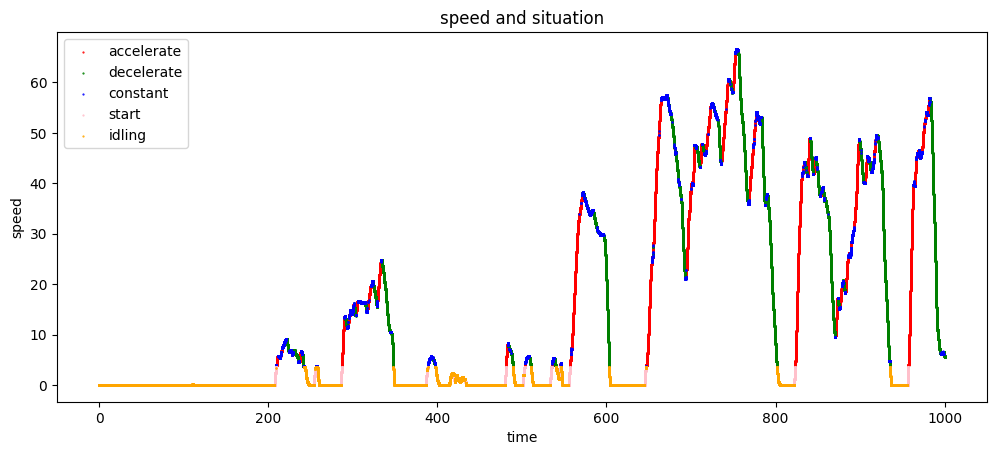

In [ ]:
# 查看标记的运动状态的情况
# 调整可以看见的时间段，准备画图数据
start = 0
end = 1000
acceleratedf = kinematic[(kinematic['situation']=="accelerate")&(kinematic['timestamps']>start)&(kinematic['timestamps']<end)]
deceleratedf = kinematic[(kinematic['situation']=="decelerate")&(kinematic['timestamps']>start)&(kinematic['timestamps']<end)]
constantdf = kinematic[(kinematic['situation']=="constant")&(kinematic['timestamps']>start)&(kinematic['timestamps']<end)]
startdf = kinematic[(kinematic['situation']=="start")&(kinematic['timestamps']>start)&(kinematic['timestamps']<end)]
idlingdf = kinematic[(kinematic['situation']=="idling")&(kinematic['timestamps']>start)&(kinematic['timestamps']<end)]

# 画图查看运动情况
fig = plt.figure()
fig.set_figwidth(12)
Size = 0.3
ax = fig.add_subplot(111)
ax.set(title = 'speed and situation',xlabel = 'time',ylabel = 'speed')
ax.scatter(acceleratedf['timestamps'],acceleratedf['speed(km/h)'],s=Size,color = 'red',label = 'accelerate')
ax.scatter(deceleratedf['timestamps'],deceleratedf['speed(km/h)'],s=Size,color = 'green',label = 'decelerate')
ax.scatter(constantdf['timestamps'],constantdf['speed(km/h)'],s=Size,color = 'blue',label = 'constant')
ax.scatter(startdf['timestamps'],startdf['speed(km/h)'],s=Size,color = 'pink',label = 'start')
ax.scatter(idlingdf['timestamps'],idlingdf['speed(km/h)'],s=Size,color = 'orange',label = 'idling')

plt.legend()
plt.show()

In [ ]:

id = 0
# 用id标记不同的运动片段的名称,两个怠速之间就是一个运动片段
print('in total:',len(kinematic))
for index,_ in kinematic.iterrows():
    print('\r',index,end='')
    if kinematic.loc[index,'situation'] == "idling":
        continue
    kinematic.loc[index,'id'] = id
    if index < len(kinematic):
        if kinematic.loc[index + 1,'situation'] == "idling": id += 1
# 查看运动片段的情况
print("pieces number",len(kinematic['id'].unique()))
# 去掉不属于运动片段的运动点
movePieces = kinematic.dropna(axis=0,subset=['id'])
# 保存最终处理好的运动片段
movePieces.to_csv(movePiecesPath)

in total: 2432495
 2684401pieces number 124


In [ ]:
movePieces.describe()

,timestamps,speed(km/h),acceleration,total_driven_distance,inclination,AC_consumption,output_power,id
count,1.959036e+06,1.959036e+06,1.959036e+06,1.959036e+06,1.959036e+06,1.959036e+06,1.959036e+06,1.959036e+06
mean,4.059229e+03,6.402345e+01,-5.663769e-02,1.391906e+04,7.522086e-03,1.083262e+00,1.226211e+01,8.848529e+01
std,2.141095e+03,3.331012e+01,6.308987e-01,3.430649e+01,1.016400e-02,1.852823e+01,2.090914e+01,2.710600e+01
min,2.071933e+02,0.000000e+00,-3.510500e+00,1.387300e+04,-5.755695e-02,0.000000e+00,-9.650000e+01,0.000000e+00
25%,2.263385e+03,4.192926e+01,-3.074660e-01,1.388900e+04,1.626511e-03,0.000000e+00,3.606635e-01,6.300000e+01
50%,4.098341e+03,5.842948e+01,-9.350000e-02,1.391100e+04,6.865360e-03,0.000000e+00,8.410161e+00,1.020000e+02
75%,5.580426e+03,9.521006e+01,2.145922e-01,1.395200e+04,1.278120e-02,0.000000e+00,2.356323e+01,1.020000e+02
max,8.130306e+03,1.349607e+02,3.094000e+00,1.397700e+04,8.508418e-02,6.400000e+02,1.607500e+02,1.220000e+02


### Step5: PCA Setup

In [ ]:
# 开始构建特征，因为特征中有些部分需要构建百分比，因此先进行计算为后面的情况做准备
# 计算统计表，统计每组（根据id）的个数
GroupNum = pd.DataFrame()
GroupNum['id'] = movePieces.groupby('id').count().index
GroupNum['number'] = movePieces.groupby('id').count()['timestamps']
GroupNum.head(5)

# 根据分组统计
for status in ['start','accelerate','decelerate','constant']:
    acc = movePieces[movePieces['situation']== status][['situation','id']].groupby('id').count()
    acc = acc.rename(columns={'situation':status})
    GroupNum = GroupNum.merge(acc,'left',None,left_on= "id",right_on="id")
    GroupNum[status] = GroupNum[status]/GroupNum['number']

# 对于一段中不存在的状态填充0值
GroupNum = GroupNum.fillna(0)

In [ ]:
# 根据movePieces1构建特征
# 平均爬升角度
inclineAvg = movePieces['inclination'].groupby(movePieces['id']).mean()
# 平均AC能量消耗
acconsumptionAvg= movePieces['AC_consumption'].groupby(movePieces['id']).mean()
# 平均速度
speedAvg = movePieces['speed(km/h)'].groupby(movePieces['id']).mean()
speedAvg.name = 'speedAvg'
# 最大速度
maxSpeed = movePieces['speed(km/h)'].groupby(movePieces['id']).max()
maxSpeed.name = 'maxSpeed'
# 里程
mileage = movePieces['total_driven_distance'].groupby(movePieces['id']).max() - movePieces['total_driven_distance'].groupby(movePieces['id']).min()
mileage.name = 'mileage'
# 起步时间占比
startPercent = GroupNum['start']
startPercent.name = 'startPercent'
# 加速时间占比
accPercent = GroupNum['accelerate']
accPercent.name = 'accPercent'
# 减速时间占比
decePercent = GroupNum['decelerate']
decePercent.name = 'decePercent'
# 匀速时间占比
consPercent = GroupNum['constant']
consPercent.name = 'consPercent'
# 平均加速度
acceleratePGroup = movePieces[movePieces['acceleration']>=0]['acceleration'].groupby(movePieces['id']).mean()
acceleratePGroup.name = 'acceleratePAvg'
# 平均减速度
accelerateNGroup = movePieces[movePieces['acceleration']<0]['acceleration'].groupby(movePieces['id']).mean()
accelerateNGroup.name = 'acceleratNPAvg'
# 加速度方差
accelerateVar = movePieces['acceleration'].groupby(movePieces['id']).var()
accelerateVar.name = 'accelerateVar'
# 速度方差
speedVar = movePieces['speed(km/h)'].groupby(movePieces['id']).var()
speedVar.name = 'speedVar'
# 加速度95%分位数
acceleratP95Q = movePieces[movePieces['acceleration']>=0]['acceleration'].groupby(movePieces['id']).quantile(0.95)
acceleratP95Q.name = 'acceleratP95Q'
# 减速5%分位数
acceleratN5Q = movePieces[movePieces['acceleration']<0]['acceleration'].groupby(movePieces['id']).quantile(0.05)
acceleratN5Q.name = 'acceleratN5Q'
# 行驶时间
time = movePieces['timestamps'].groupby(movePieces['id']).max() - movePieces['timestamps'].groupby(movePieces['id']).min()
time.name = 'time'

In [ ]:
# 得到构建的运动片段库
moveCollections = pd.concat([inclineAvg,acconsumptionAvg,speedAvg,maxSpeed,mileage,startPercent,accPercent,decePercent,consPercent,acceleratePGroup,accelerateNGroup,accelerateVar,speedVar,acceleratP95Q,acceleratN5Q,time],axis=1)
# 查看缺失值的情况
moveCollections.isnull().any()
# 对于缺失值进行填充
moveCollections['acceleratNPAvg'] = moveCollections['acceleratNPAvg'].fillna(0)
moveCollections['acceleratN5Q'] = moveCollections['acceleratN5Q'].fillna(0)
moveCollections['id'] = moveCollections.index
moveCollections.describe()

,inclination,AC_consumption,speedAvg,maxSpeed,mileage,startPercent,accPercent,decePercent,consPercent,acceleratePAvg,acceleratNPAvg,accelerateVar,speedVar,acceleratP95Q,acceleratN5Q,time,id
count,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000
mean,0.009971,0.651898,11.143673,16.064301,0.845528,0.626291,0.094176,0.174371,0.105162,0.333964,-0.193451,0.184234,57.909120,0.663510,-0.504131,49.971021,61.000000
std,0.007725,3.693138,18.095354,26.403242,6.082806,0.466359,0.145881,0.228565,0.170934,0.225665,0.283149,0.327714,115.239835,0.669418,0.732777,248.241340,35.651087
min,-0.008884,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027993,-1.184852,0.000000,0.000000,0.058953,-2.448198,0.000380,0.000000
25%,0.006293,0.000000,0.317151,0.391626,0.000000,0.032986,0.000000,0.000000,0.000000,0.162017,-0.388765,0.000089,0.000060,0.170000,-0.861730,0.035435,30.500000
50%,0.009224,0.000000,3.144470,3.345351,0.000000,1.000000,0.000000,0.000000,0.000000,0.267779,0.000000,0.006307,0.061724,0.370171,0.000000,0.704460,61.000000
75%,0.013894,0.000000,6.246853,9.754668,0.000000,1.000000,0.193392,0.424651,0.169937,0.471522,0.000000,0.165373,4.002308,0.913731,0.000000,16.587170,91.500000
max,0.030815,28.354923,93.857205,134.960688,67.000000,1.000000,0.512952,0.664083,0.859477,1.172148,0.000000,1.508344,423.316110,2.626246,0.000000,2609.525340,122.000000


可以看见，数据在速度的方差和时间存在差异较大的情况，因此选择标准化而不是归一化

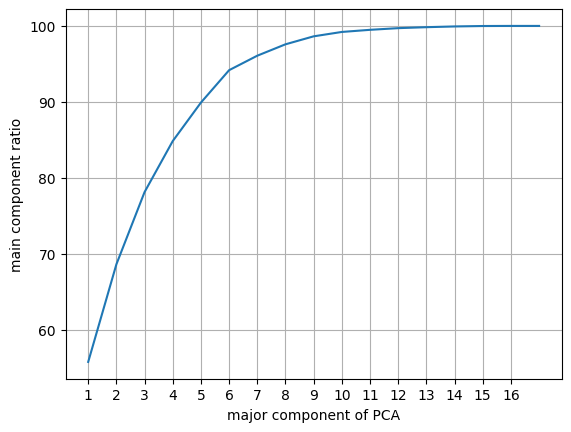

In [ ]:
# 标准化数据，并且利用PCA的方式降维，为后面的聚类做准备
# 构建PCA模型
moveCollections_norm = (moveCollections-moveCollections.mean())/moveCollections.std()
pca = PCA()
pca.fit(np.array(moveCollections_norm))

# 查看训练后的解释情况
import plotly.express as px
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
plt.xticks(np.arange(1,17))
plt.ylabel('main component ratio')
plt.xlabel('major component of PCA')
plt.grid()
plt.plot(np.arange(1,18),exp_var_cumul*100)

In [ ]:
varianceRatio = pd.DataFrame(pca.explained_variance_ratio_)
varianceRatio=varianceRatio.rename(columns={0:'ratio'})

varianceRatio['ratio'] = varianceRatio['ratio']*100
varianceRatio['cummulative'] = np.cumsum(varianceRatio['ratio'])
varianceRatio['ratio'] = varianceRatio['ratio'].apply(int).apply(str)
varianceRatio['cummulative'] = varianceRatio['cummulative'].apply(int).apply(str)
varianceRatio['ratio'] = varianceRatio['ratio'] + '%'
varianceRatio['cummulative'] = varianceRatio['cummulative'] + '%'
# 查看PCA降维找到的百分比的情况
varianceRatio

,ratio,cummulative
0,55%,55%
1,12%,68%
2,9%,78%
3,6%,84%
4,5%,89%
5,4%,94%
6,1%,96%
7,1%,97%
8,1%,98%
9,0%,99%


4个主成分来衡量

In [ ]:
# 找到前4个factor的计算方法进行保存
pcaDf = pd.DataFrame(pca.components_[:4],columns=moveCollections.columns)
pcaDf.to_csv(pcaPath)

In [ ]:
pcaDf

,inclination,AC_consumption,speedAvg,maxSpeed,mileage,startPercent,accPercent,decePercent,consPercent,acceleratePAvg,acceleratNPAvg,accelerateVar,speedVar,acceleratP95Q,acceleratN5Q,time,id
0,-0.009230,0.119657,0.297535,0.301939,0.099463,-0.280520,0.306639,0.276087,0.134477,0.250625,-0.297512,0.293993,0.296125,0.293155,-0.307457,0.128908,0.080299
1,-0.092801,-0.112883,0.185132,0.178071,0.624719,0.041906,-0.098342,-0.060487,0.050476,-0.178807,0.158621,-0.180489,0.088722,-0.122622,0.121423,0.607700,0.089971
2,0.346490,-0.156157,-0.086582,-0.105267,-0.019415,-0.374165,-0.031061,0.311144,0.631297,-0.309870,-0.068569,-0.146244,-0.187598,-0.180519,-0.068061,-0.022499,0.072579
3,0.635795,-0.011697,0.070928,0.068186,0.093519,0.043958,-0.001690,-0.007782,-0.108083,0.114780,0.060035,-0.022897,0.052321,0.090804,0.042038,0.083110,-0.725648


### Step6: Kmeans Classification

In [ ]:
# 利用pca找到的信息对数据进行转化准备好Kmeans的输入数据
newData = np.array(moveCollections_norm).dot(np.array(pcaDf.transpose()))
newDf = pd.DataFrame(columns=['factor1','factor2','factor3','factor4'],data = newData)


In [ ]:
# 使用轮廓系数，寻找KMeans的最佳的聚类数
for k in range(10):
    Kmeans = KMeans(n_clusters=k+2,n_init="auto").fit(newData)
    print("分类数为{}的时候，轮廓系数评分为{}".format(k+1,silhouette_score(newData,Kmeans.labels_)))

分类数为1的时候，轮廓系数评分为0.6364357701446463
分类数为2的时候，轮廓系数评分为0.5820934296670425
分类数为3的时候，轮廓系数评分为0.6000276148419611
分类数为4的时候，轮廓系数评分为0.5151966361360535
分类数为5的时候，轮廓系数评分为0.4721098228956181
分类数为6的时候，轮廓系数评分为0.42228535870104367
分类数为7的时候，轮廓系数评分为0.43204790215771544
分类数为8的时候，轮廓系数评分为0.38995260117622654
分类数为9的时候，轮廓系数评分为0.3980783079938643
分类数为10的时候，轮廓系数评分为0.3725806004016991


当轮廓系数最大的时候，分类的效果最好，因此我们选择分类为3类

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


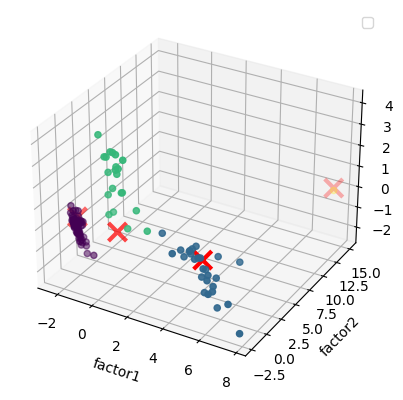

In [ ]:
# 构建模型
Kmeans = KMeans(n_clusters = 4,n_init="auto").fit(newData)
# 得到聚类类别标签 Kmeans.labels_，根据此标签进行画图
ax = plt.axes(projection = '3d')
xline = np.array(newDf['factor1'])
yline = np.array(newDf['factor2'])
zline = np.array(newDf['factor3'])
ax.set_xlabel('factor1')
ax.set_ylabel('factor2')
ax.set_zlabel('factor3')
centroids = Kmeans.cluster_centers_

ax.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    c='red',
    zorder=10,
)



plt.legend()
color = Kmeans.labels_
ax.scatter3D(xline,yline,zline,c=color)

结合factor的计算的形式，对于分类结果进行解释
第一类为拥堵路段，低速行驶的情况
第二类为高速上的状态
第三类为城区不太拥堵的地方的状态

In [ ]:
# 将label的信息加在运动片段上
idLabel = np.vstack([np.array(moveCollections.index),Kmeans.labels_])
idLabel = pd.DataFrame(idLabel)
idLabel = idLabel.transpose()
idLabel = idLabel.rename(columns = {0:'id',1:'label'})
movePieces = movePieces.merge(idLabel,'left',None,left_on = "id",right_on='id')
moveCollections = moveCollections.merge(idLabel,'left',None,left_on = "id",right_on='id')
# 最新的数据更新保存一下
movePieces.to_csv(movePiecesPath)
moveCollections.to_csv(moveCollectionsPath)

In [ ]:
# 根据标签查看不同类别路况的片段的速度情况
# 绘制典型的路况的情况图
# 准备第一类的数据
label1 = movePieces[movePieces['label']==0]
label2 = movePieces[movePieces['label']==1]
label3 = movePieces[movePieces['label']==2]
label4 = movePieces[movePieces['label']==3]



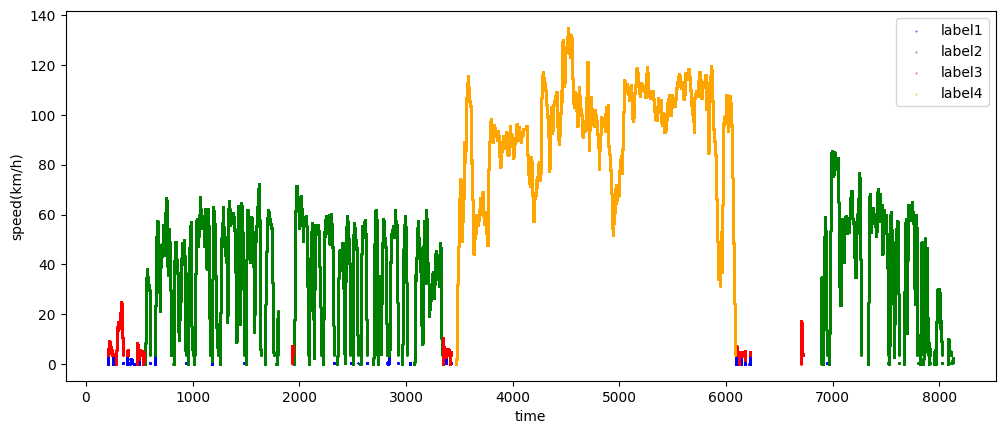

In [ ]:
fig = plt.figure()
fig.set_figwidth(12)
Size = 0.1
ax = fig.add_subplot(111)
ax.set(xlabel='time',ylabel='speed(km/h)')
ax.scatter(label1['timestamps'],label1['speed(km/h)'],s=Size,color = 'blue',label = 'label1')
ax.scatter(label2['timestamps'],label2['speed(km/h)'],s=Size,color = 'green',label = 'label2')
ax.scatter(label3['timestamps'],label3['speed(km/h)'],s=Size,color = 'red',label = 'label3')
ax.scatter(label4['timestamps'],label4['speed(km/h)'],s=Size,color = 'orange',label = 'label4')
plt.legend()
plt.show()

In [ ]:
# 构建平均能耗消耗情况
movePieces = movePieces.merge(df[['timestamps','output_power']],'left',None,left_on = 'timestamps',right_on = 'timestamps')
moveCollectionEnergy = movePieces[['id','output_power']].groupby('id').sum()
moveCollections = moveCollections.merge(moveCollectionEnergy,'left',None,left_on = 'id',right_on = 'id')
moveCollections['energyPerSecond'] = moveCollections['output_power'] / moveCollections['time']
movePieces = movePieces.merge(moveCollections[['id','energyPerSecond']],'left',left_on = 'id',right_on = 'id')

In [ ]:
centroids

array([[-2.09932341,  0.09448591, -0.51055932,  0.04865479],
       [ 5.19678515, -0.57385902, -0.48025067,  0.03229438],
       [ 0.35946831, -0.30662439,  2.42231871, -0.27163111],
       [ 7.48789855, 14.94134827, -0.12053525,  1.2318508 ]])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


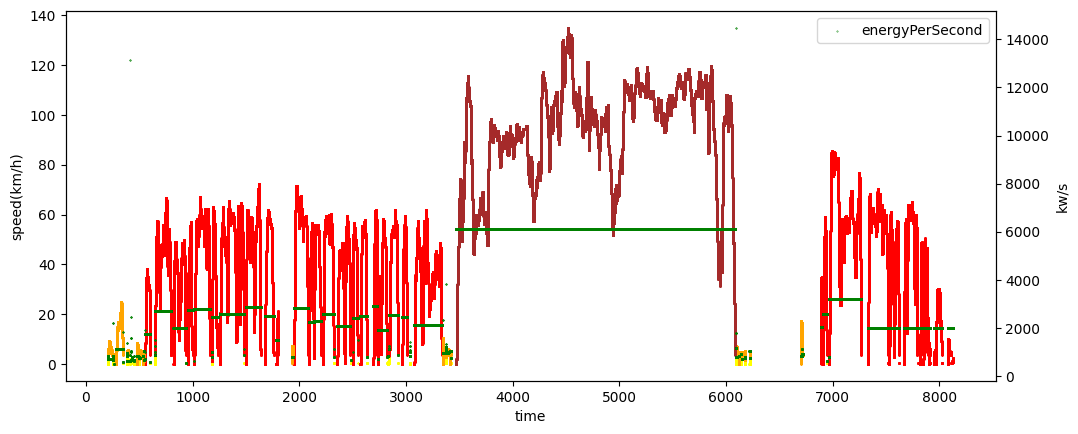

In [ ]:
# 画出能耗消耗情况以及路况的关系,其中能耗用每个速度片段的，时间平均能耗进行计算
label1 = movePieces[movePieces['label']==0]
label2 = movePieces[movePieces['label']==1]
label3 = movePieces[movePieces['label']==2]
label4 = movePieces[movePieces['label']==3]


fig = plt.figure()
fig.set_figwidth(12)
Size = 0.1
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.set(xlabel='time',ylabel='speed(km/h)')
ax2.set(ylabel='kw/s')

ax1.scatter(label1['timestamps'],label1['speed(km/h)'],s=Size,color = 'yellow',label = 'label1')
ax1.scatter(label2['timestamps'],label2['speed(km/h)'],s=Size,color = 'red',label = 'label2')
ax1.scatter(label3['timestamps'],label3['speed(km/h)'],s=Size,color = 'orange',label = 'label3')
ax1.scatter(label4['timestamps'],label4['speed(km/h)'],s=Size,color = 'brown',label = 'label4')
plt.legend()

ax2.scatter(movePieces['timestamps'],movePieces['energyPerSecond'],s=Size,color = 'green',label = 'energyPerSecond')
plt.legend()
plt.show()

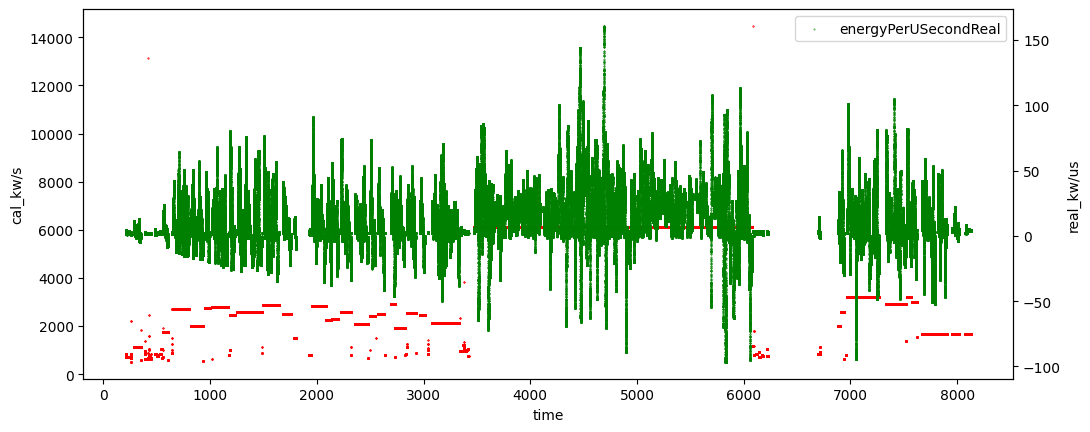

In [ ]:
# 画出实际的能耗和一段的平均能耗的关系
fig = plt.figure()
fig.set_figwidth(12)
Size = 0.1
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.set(xlabel='time',ylabel='cal_kw/s')
ax2.set(ylabel='real_kw/us')

ax1.scatter(movePieces['timestamps'],movePieces['energyPerSecond'],s=Size,color = 'red',label = 'energyPerSecondCal')
ax2.scatter(movePieces['timestamps'],movePieces['output power'],s=Size,color = 'green',label = 'energyPerUSecondReal')
plt.legend()
plt.show()

In [ ]:
# 构建最后的输出的情况和对应能耗的表
# 预计高德的输入：长度,通行时间,速度大小

In [1]:
moveCollections

NameError: name 'moveCollections' is not defined